# CIFAR-10 tiny images

The *CIFAR-10* data set is a collection of tiny digital images, with simple text labels assigned to each image, reflecting the content of the image.

__Contents:__
- <a href="#overview">Overview of the data set</a>
- <a href="#data_check">Examining the (image, label) pairs</a>
- <a href="#make_h5">Prepare for training and evaluation</a>
___

<a id="overview"></a>
## Overview of the data set

At present (July 2018), the CIFAR-10 data set is hosted by the University of Toronto, and is easily accessed via the home page of Alex Krizhevsky:

```
http://www.cs.toronto.edu/~kriz/cifar.html
```

This dataset is a subset of the *Tiny Images* dataset, a large data set of nearly 80 million images with thousands of distinct labels [<a href="http://horatio.cs.nyu.edu/mit/tiny/data/index.html">link</a>]. For reference, __CIFAR__ is an acronym, and stands for the __C__anadian __I__nstitute __f__or __A__dvanced __R__esearch.

The CIFAR-10 dataset is typically used for training image classification systems, and includes just ten distinct labels: *airplane*, *automobile*, *bird*, *cat*, *deer*, *dog*, *frog*, *horse*, *ship*, and *truck*. See an example below:

<img src="img/cifar-10.png" alt="CIFAR-10 examples" />

Basic facts:

- 60,000 images
- 32x32 colour images
- 10 classes
- Balanced classes (6,000 images per class)

Let's get started. Let's prepare a sub-directory called `cifar10` to store the data. There are three versions of the data available: a Python version, MATLAB version, and binary version. While the Python version is perfectly acceptable, let's prepare using the binary version.

```
$ cd data/cifar10
$ wget http://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz
$ tar -xzf cifar-10-binary.tar.gz
```

A directory `cifar-10-batches-bin` is created, with content as follows:

```
$ ls cifar-10-batches-bin
batches.meta.txt  data_batch_2.bin  data_batch_4.bin  readme.html
data_batch_1.bin  data_batch_3.bin  data_batch_5.bin  test_batch.bin
```

The `batches.meta.txt` file just contains label names, one per line. What remains are six batches in binary format: five training batches (`data_batch_*.bin`) and one test batch (`test_batch.bin`). Each batch has 10,000 images. Regarding the balance of classes:

> The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class. 

Time to dig in to the binary files.
___

<a id="data_check"></a>
## Examining the (image, label) pairs

Let us begin by opening a file connection with the training examples.


In [1]:

import numpy as np
import matplotlib.pyplot as plt

toread = "data/cifar10/cifar-10-batches-bin/data_batch_1.bin"

f_bin = open(toread, mode="rb")

print(f_bin)


<_io.BufferedReader name='data/cifar10/cifar-10-batches-bin/data_batch_1.bin'>


Next we make sure that we know how to read the data correctly. The only way to do this is to confirm by inspection, verifying that the content we read is the content the authors tell us we should be reading. From the documentation, the file format is extremely simple:

- The basic format is `<1 x label><3072 x pixel>`, namely one byte containing the label, and 3072 bytes containing pixel information. Thus the first 3073 bytes contain all the information required for the first (image,label) pair. This "row" of data occurs 10,000 times per batch.
- Labels are integers between 0 and 9.
- Images are 32 x 32 = 1024 pixels, one byte per pixel. These pixel values are stored one colour channel at a time: red, green, blue.
- Values are stored in *row-major* order, so we populate by rows, rather than by columns.

This is enough information to get started.

In [2]:
print("First byte:") # should be a label.
b = f_bin.read(1)
print("bytes: ", b)
print("int: ", int.from_bytes(b, byteorder="big", signed=False))

First byte:
bytes:  b'\x06'
int:  6


Note that the byte data `b'\x06'` shown here by Python is a hexadecimal representation of the first byte. The ``\x`` breaks simply show where one byte starts and another ends, recalling that using two hexadecimal digits we can represent the integers from $0, 1, 2, \ldots$ through to $(15 \times 16^{1} + 15 \times 16^{0}) = 255$, just as we can with 8 binary digits, or 1 *byte*.

Let's look at the content of the next five pixel values, assuming they are unsigned integers.

In [3]:
for i in range(5):
    b = f_bin.read(1)
    print("bytes: ", b)
    print("int: ", int.from_bytes(b, byteorder="big", signed=False))

bytes:  b';'
int:  59
bytes:  b'+'
int:  43
bytes:  b'2'
int:  50
bytes:  b'D'
int:  68
bytes:  b'b'
int:  98


Well, the pixel values are similar, but whether or not this is correct remains to be seen. Let's `seek()` back to the first pixel value, and read out the whole image into a numpy array.

In [4]:
f_bin.seek(1)
my_array = np.zeros((32,32,3), dtype=np.uint8)
for c in range(3): # colour channel
    for i in range(32): # rows
        for j in range(32): # columns
            b = f_bin.read(1)
            my_array[i,j,c] = int.from_bytes(b, byteorder="big", signed=False)

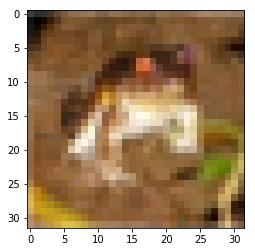

In [5]:
plt.imshow(my_array)

This looks like an image of a frog. The label is 6, namely the seventh label, and from the file `batches.meta.txt` we have

```
$ cat batches.meta.txt
airplane
automobile
bird
cat
deer
dog
frog
horse
ship
truck
```

which lets us confirm that the label is as we expect. Let's do one more (image,label) pair.

In [6]:
b = f_bin.read(1)
print("bytes: ", b)
print("int: ", int.from_bytes(b, byteorder="big", signed=False))
my_array = np.zeros((32,32,3), dtype=np.uint8)
for c in range(3): # colour channel
    for i in range(32): # rows
        for j in range(32): # columns
            b = f_bin.read(1)
            my_array[i,j,c] = int.from_bytes(b, byteorder="big", signed=False)

bytes:  b'\t'
int:  9


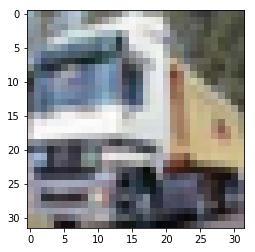

In [7]:
plt.imshow(my_array)

We have an image of a truck, with label value 9, the tenth label. This is precisely as we would expect. Let's close the file for now, and proceed with processing the entire data set.

<a id="make_h5"></a>
## Prepare for training and evaluation

In the previous section, we used 3D arrays for visualizing the image contents. For learning, each image will just be a long vector, contained within a 2D array whose rows correspond to distinct images. This array itself will be contained in a hierarchical data file that is quite convenient for fast reading. To do this, we use __PyTables__, a well-established Python package for managing hierarchical data sets and reading/writing large amounts of data [<a href="http://www.pytables.org/">link</a>].

We begin by generating a new file.

In [1]:
import tables
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
# Key information.
NUM_CLASSES = 10
NUM_LABELS = 1
NUM_PIXELS = 32*32
NUM_CHANNELS = 3
NUM_BATCHIM = 10000 # number of images per batch.

# A dictionary mapping label values (ints) to strings.
toread = "data/cifar10/cifar-10-batches-bin/batches.meta.txt"
LABEL_DICT = {}
with open(toread, mode="r", encoding="ascii") as f:
    for cnt, line in enumerate(f):
        LABEL_DICT[cnt] = line.split("\n")[0] # to remove the line-breaks.
    LABEL_DICT.pop(10) # to remove the empty line.

In [3]:
# Open file connection, writing new file to disk.
myh5 = tables.open_file("data/cifar10/data.h5",
                        mode="w",
                        title="CIFAR-10 data")
print(myh5) # currently empty.

data/cifar10/data.h5 (File) 'CIFAR-10 data'
Last modif.: 'Tue Jul  3 11:13:20 2018'
Object Tree: 
/ (RootGroup) 'CIFAR-10 data'



Within the `RootGroup`, let us add two new groups for training and testing.

In [4]:
myh5.create_group(myh5.root, "train", "Training data")
myh5.create_group(myh5.root, "test", "Testing data")
print(myh5)

data/cifar10/data.h5 (File) 'CIFAR-10 data'
Last modif.: 'Tue Jul  3 11:13:20 2018'
Object Tree: 
/ (RootGroup) 'CIFAR-10 data'
/test (Group) 'Testing data'
/train (Group) 'Training data'



Within `train` and `test`, prepare *enumerative array* (`EArray` class) objects which will be used for storing data. Enumerative arrays are different from typical `Array` objects in that new data can be added freely at a later date.

In [5]:
# Training data arrays.
a = tables.UInt8Atom()
myh5.create_earray(myh5.root.train,
                   name="labels",
                   atom=a,
                   shape=(0,NUM_LABELS),
                   title="Label values")
a = tables.Float32Atom()
myh5.create_earray(myh5.root.train,
                   name="inputs",
                   atom=a,
                   shape=(0,NUM_CHANNELS*NUM_PIXELS),
                   title="Input images")

# Testing data arrays.
a = tables.UInt8Atom()
myh5.create_earray(myh5.root.test,
                   name="labels",
                   atom=a,
                   shape=(0,NUM_LABELS),
                   title="Label values")
a = tables.Float32Atom()
myh5.create_earray(myh5.root.test,
                   name="inputs",
                   atom=a,
                   shape=(0,NUM_CHANNELS*NUM_PIXELS),
                   title="Input images")

print(myh5)

data/cifar10/data.h5 (File) 'CIFAR-10 data'
Last modif.: 'Tue Jul  3 11:13:20 2018'
Object Tree: 
/ (RootGroup) 'CIFAR-10 data'
/test (Group) 'Testing data'
/test/inputs (EArray(0, 3072)) 'Input images'
/test/labels (EArray(0, 1)) 'Label values'
/train (Group) 'Training data'
/train/inputs (EArray(0, 3072)) 'Input images'
/train/labels (EArray(0, 1)) 'Label values'



The arrays are ready to be populated. Note that the first dimension is the "enlargeable dimension". It starts with no entries and is thus zero, but grows as we append data.

We shall carry out just one simple bit of pre-processing: normalization of pixel values to the unit interval $[0,1]$. This is accomplished by dividing existing pixels by 255. We handle all training batches at once, as below.

In [7]:
def process_inputs(x):
    '''
    Normalization of the inputs.
    '''
    return np.float32(x/255.0)

In [10]:
todo_batches = [1, 2]

# Storage preparation.
datum_input = np.zeros((NUM_CHANNELS*NUM_PIXELS,), dtype=np.float32)
datum_label = np.zeros((1,), dtype=np.uint8)

# Loop over the batch itinerary.
for b in todo_batches:
    
    fname = "data_batch_" + str(b) + ".bin"
    toread = os.path.join("data", "cifar10", "cifar-10-batches-bin", fname)
    f_bin = open(toread, mode="rb")
    
    print("--", "BATCH", b, "--")
    
    for i in range(NUM_BATCHIM):
        if i % 1000 == 0:
            print("Working... image", i)
            
        b = f_bin.read(1)
        datum_label[0] = int.from_bytes(b, byteorder="big", signed=False)

        for j in range(NUM_CHANNELS*NUM_PIXELS):
            # Populate a long vector.
            b = f_bin.read(1)
            datum_input[j] = int.from_bytes(b, byteorder="big", signed=False)
            
        # Append.
        myh5.root.train.inputs.append([process_inputs(datum_input)]) # inputs
        myh5.root.train.labels.append([datum_label]) # labels
    
    f_bin.close()


-- BATCH 1 --
Working... image 0
Working... image 1000
Working... image 2000
Working... image 3000
Working... image 4000
Working... image 5000
Working... image 6000
Working... image 7000
Working... image 8000
Working... image 9000
-- BATCH 2 --
Working... image 0
Working... image 1000
Working... image 2000
Working... image 3000
Working... image 4000
Working... image 5000
Working... image 6000
Working... image 7000
Working... image 8000
Working... image 9000


Having run the above code, we can clearly see that the desired number of observations have been added to the arrays under the `train` group. 

In [11]:
print(myh5)

data/cifar10/data.h5 (File) 'CIFAR-10 data'
Last modif.: 'Tue Jul  3 11:15:37 2018'
Object Tree: 
/ (RootGroup) 'CIFAR-10 data'
/test (Group) 'Testing data'
/test/inputs (EArray(0, 3072)) 'Input images'
/test/labels (EArray(0, 1)) 'Label values'
/train (Group) 'Training data'
/train/inputs (EArray(20000, 3072)) 'Input images'
/train/labels (EArray(20000, 1)) 'Label values'



Let's do the same thing for the `test` group below.

In [12]:

# Storage preparation.
datum_input = np.zeros((NUM_CHANNELS*NUM_PIXELS,), dtype=np.float32)
datum_label = np.zeros((1,), dtype=np.uint8)

# Loop over the batch itinerary.
fname = "test_batch.bin"
toread = os.path.join("data", "cifar10", "cifar-10-batches-bin", fname)
f_bin = open(toread, mode="rb")
    
print("--", "TEST BATCH", "--")
    
for i in range(NUM_BATCHIM):
    if i % 1000 == 0:
        print("Working... image", i)
            
    b = f_bin.read(1)
    datum_label[0] = int.from_bytes(b, byteorder="big", signed=False)

    for j in range(NUM_CHANNELS*NUM_PIXELS):
        # Populate a long vector.
        b = f_bin.read(1)
        datum_input[j] = int.from_bytes(b, byteorder="big", signed=False)
            
    # Append.
    myh5.root.test.inputs.append([process_inputs(datum_input)]) # inputs
    myh5.root.test.labels.append([datum_label]) # labels
    
f_bin.close()


-- TEST BATCH --
Working... image 0
Working... image 1000
Working... image 2000
Working... image 3000
Working... image 4000
Working... image 5000
Working... image 6000
Working... image 7000
Working... image 8000
Working... image 9000


Let's do one final check of the content, and close the final connection.

In [13]:
print(myh5)
myh5.close()

data/cifar10/data.h5 (File) 'CIFAR-10 data'
Last modif.: 'Tue Jul  3 11:20:18 2018'
Object Tree: 
/ (RootGroup) 'CIFAR-10 data'
/test (Group) 'Testing data'
/test/inputs (EArray(10000, 3072)) 'Input images'
/test/labels (EArray(10000, 1)) 'Label values'
/train (Group) 'Training data'
/train/inputs (EArray(20000, 3072)) 'Input images'
/train/labels (EArray(20000, 1)) 'Label values'



Finally, let us ensure that our new file houses data in the form that we expect.

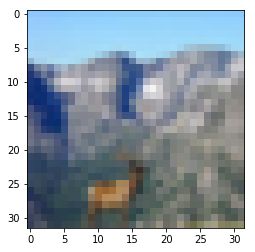

LABEL: 4 = deer


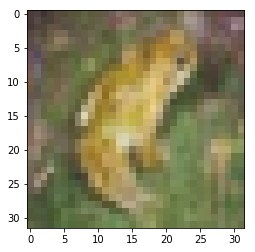

LABEL: 6 = frog


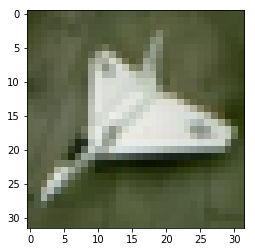

LABEL: 0 = airplane


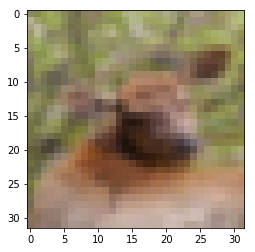

LABEL: 4 = deer


In [21]:
# Read an arbitrary image.
f = tables.open_file("data/cifar10/data.h5", mode="r")
todo_vals = [1509, 1959, 1988, 9018]
for i in range(len(todo_vals)):
    todo = todo_vals[i]
    myinput = f.root.train.inputs.read(start=todo, stop=(todo+1), step=1)
    mylabel = f.root.train.labels.read(start=todo, stop=(todo+1), step=1)
    myim = myinput.flatten().reshape((3,32,32))
    myim = np.swapaxes(myim, 0, 1) # note the axis swapping.
    myim = np.swapaxes(myim, 1, 2) # note the axis swapping.
    plt.imshow(myim)
    plt.show()
    print("LABEL:", mylabel[0][0], "=", LABEL_DICT[mylabel[0][0]])
f.close()

__TODO: Exercises___

- Count the number of each label
- Make grayscale images for dim reducation (just luminosity, etc.)

Add a few simple exercises to keep 'em busy.

___